In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

import pandas as pd 
import numpy as np
import os
import glob
import json
import matplotlib.pyplot as plt

## Reading Images

First the images will be read with the PIL library (to instantiate an object for each image and save in a 2D list to later create a pandas DataFrame)

The PIL library since an image object is created when reading the image, making it conveninent to get certain attributes from an image (height, width, etc.)

Later on to pass images to the model, a keras generator will be used.

In [2]:
image_files = []

for folder in ['fully_covered', 'not_covered', 'not_face', 'partially_covered']:

    # go through all the files
    for file in glob.glob(pathname='../data/' + folder + "/*.jpg"):

        # load the image and append it to initial list
        img = Image.open(file)

        # specify the list to append to the final list
        image_files.append([img, file, folder])

## Explore Image Data

Now that the images are read, image characeristics will be explored:

* What is the width range? (by pixels)
* What is the height range? (by pixels)
* What color channels are the images in?

While these questions could be answered by reading the documentation, the steps below are good to implement to double check the data quality

In [3]:
# create dataframe with 2-D list

data = pd.DataFrame(image_files, columns = ["image_object", 'filename', "target_class"])

In [4]:
# investigate images data by setting columns
data["filename"] = data["image_object"].apply(lambda d: d.filename)

# get height from image object
data["height_pixels"] = data["image_object"].apply(lambda d: d.height)

# get width from image object
data["width_pixels"] = data["image_object"].apply(lambda d: d.width)

# apply the mode
data["mode"] = data["image_object"].apply(lambda d: d.mode)

{'whiskers': [<matplotlib.lines.Line2D at 0x2993865b828>,
 'caps': [<matplotlib.lines.Line2D at 0x2993865bdd8>,
 'boxes': [<matplotlib.lines.Line2D at 0x2993865b588>],
 'medians': [<matplotlib.lines.Line2D at 0x2993866f3c8>],
 'fliers': [<matplotlib.lines.Line2D at 0x2993866f6a0>],
 'means': []}

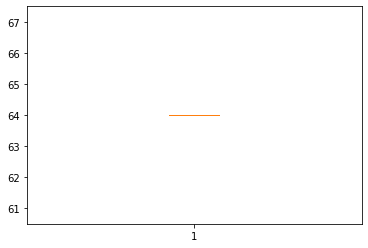

In [5]:
# boxplot for height pixels

plt.boxplot(data['height_pixels'])

All images have the same height in pixels (64)

{'whiskers': [<matplotlib.lines.Line2D at 0x299396ce6a0>,
 'caps': [<matplotlib.lines.Line2D at 0x299396cec50>,
 'boxes': [<matplotlib.lines.Line2D at 0x299396ce438>],
 'medians': [<matplotlib.lines.Line2D at 0x299396db240>],
 'fliers': [<matplotlib.lines.Line2D at 0x299396db518>],
 'means': []}

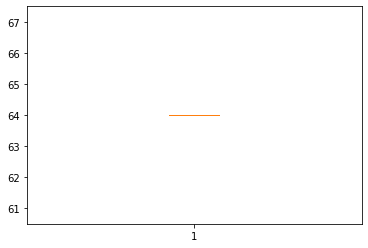

In [6]:
# histogram for height pixels

plt.boxplot(data['width_pixels'])

All images have the same width in pixels (64)

In [7]:
data["mode"].unique()

array(['L'], dtype=object)

All images are in black and white (mode L in PIL is black and white)

## Image Manipulation

To pass the images to the model, the ImageDataGenerator class from the keras.preprocessing.image module will be used.

Since the data is structured into different folders belonging to the relevant target class, the generator object will be very useful in also separating between X and y data.

To separate between Train and Test data, the validation_split attribute of the generator object will be used. The train validation split chosen will be 0.8:0.2

However, to not augment images in the validation set, we will use a separate generator for the validation set, with only the rescaling and validation_split parameters.

To make sure images from the training and validation set don't mix, we will use the same seed when generating the batches of images (method found in the following link):
https://github.com/keras-team/keras/issues/5862 

In the training image generator, a series of random steps will be applied to the images to make the model more robust.

In [8]:
# define seed - IMPORTANT SO IMAGES FROM TRAINING AND VALIDATION DONT GET MIXED UP
seed = 8

# create training generator to later pass on to training
train_gen = ImageDataGenerator(rotation_range=30, # rotate the image by 30 degrees
                               width_shift_range=0.1, # Shift the pic width by a max of 10%
                               height_shift_range=0.1, # Shift the pic height by a max of 10%
                               rescale=1/255, # Rescale the image (dividing by 255 each pixel)
                               shear_range=0.2, # Cutting max of 20% of the image 
                               zoom_range=0.2, # Zooming in by a max of 20%
                               horizontal_flip=True, # Option to flip the image horizontally
                               fill_mode='nearest', # How to fill points outside of the boundary
                               validation_split = 0.2) # 20% kept as validation data

# create validation generator, no image augmentation for training
val_gen = ImageDataGenerator(rescale=1/255,
                            validation_split=0.2)

In [9]:
# define standard image shape
image_shape = (64,64)
image_shape_rgb = (75,75)

#### Create Train and Validation

In [10]:
root_dir = r'../data'
BATCH_SIZE = 64

# create training generator for images
train_generator = train_gen.flow_from_directory(directory = root_dir,
                                                target_size= image_shape,
                                                class_mode = 'categorical',
                                                subset = 'training',
                                                shuffle = False,
                                                seed = seed,
                                                batch_size=BATCH_SIZE,
                                                color_mode='grayscale')

# create validation generator for images
val_generator = val_gen.flow_from_directory(directory = root_dir,
                                            target_size= image_shape,
                                            class_mode = 'categorical',
                                            subset = 'validation',
                                            shuffle = False,
                                            seed = seed,
                                            batch_size=BATCH_SIZE,
                                            color_mode='grayscale')


train_generator_rgb = train_gen.flow_from_directory(directory = root_dir,
                                                target_size= image_shape_rgb,
                                                class_mode = 'categorical',
                                                subset = 'training',
                                                shuffle = False,
                                                seed = seed,
                                                batch_size=BATCH_SIZE,
                                                color_mode='rgb')

val_generator_rgb = train_gen.flow_from_directory(directory = root_dir,
                                                target_size= image_shape_rgb,
                                                class_mode = 'categorical',
                                                subset = 'validation',
                                                shuffle = False,
                                                seed = seed,
                                                batch_size=BATCH_SIZE,
                                                color_mode='rgb')

Found 5299 images belonging to 4 classes.
Found 1322 images belonging to 4 classes.
Found 5299 images belonging to 4 classes.
Found 1322 images belonging to 4 classes.


In [11]:
x_batch, y_batch = val_generator.next()
x_batch_train, y_batch_train = train_generator.next()

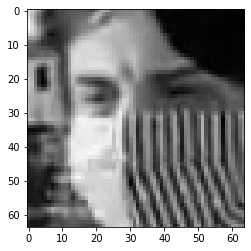

In [12]:
# Print the first image in the batch
plt.imshow(x_batch[0], cmap='gray')

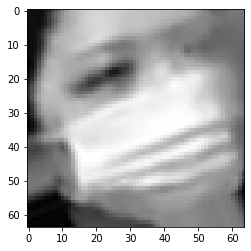

In [13]:
# Print the first image in the batch
plt.imshow(x_batch_train[0], cmap='gray')

In [14]:
x_batch_rgb, y_batch_rgb = val_generator_rgb.next()
x_batch_train_rgb, y_batch_train_rgb = train_generator_rgb.next()

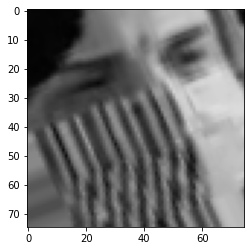

In [15]:
# Print the first image in the batch
plt.imshow(x_batch_rgb[0], cmap='gray')

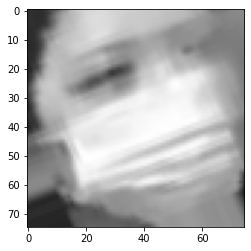

In [16]:
# Print the first image in the batch
plt.imshow(x_batch_train_rgb[0], cmap='gray')

## Create Models

To evaluate the impact of the addition of Convolutional Layers, 3 models will be created:

* One Conv2D layer with 32 filters
* 2 Conv2D layers with 32 filters each
* 3 Conv2D layers with 32 filters each

Constant parameters of the models:

* kernel size for Convolutional layers: (3,3)
* Max Pooling stride: (2,2)
* activation for Convolution and Dense layers: relu
* dense layers: 1 dense layer with 128 nodes and 1 output layer with 4 nodes (softmax activation)

The creation of the models is done in a separate module (models.py)

In [17]:
from models import ConvModel, TransferModel, MyCallback

In [18]:
# constant parameters
IMAGE_SHAPE = (64,64,1)
IMAGE_SHAPE_RGB = (75,75,3)

# convolution
ALPHA = 2
KERNEL_SIZE = (3,3)
ACTIVATION_CONV = 'relu'
BASE_LEARNING_RATE = 0.001
OUTPUT_UNITS=4

# compile parameters
LOSS = 'categorical_crossentropy'
OPTIMIZER = 'adam'
METRICS = ['accuracy']

In [19]:
"""
MODEL 1

One Conv2D layer with 32 filters

Constant parameters (specified in the notebook)
"""

conv_architecture = {1: {"layer": tf.keras.layers.Conv2D, "params": {"filters": ALPHA*64, \
    "kernel_size": KERNEL_SIZE, "activation": "relu", "input_shape": IMAGE_SHAPE}}}
pool_architecture = {1: {"layer": tf.keras.layers.MaxPooling2D, \
    "params": {"pool_size": (2,2)}}}

model_1 = ConvModel()
model_1(conv_architecture=conv_architecture, pool_architecture=pool_architecture, output_units=OUTPUT_UNITS)
model_1.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

model_1.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               31490304  
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 31,492,612
Trainable params: 31,492,612
Non-trainable params: 0
_________________________________________________________________


In [20]:
"""
MODEL 2

2 Conv2D layer with 32 filters

Constant parameters (specified in the notebook)
"""

conv_architecture_2 = {
    1 : {"layer": tf.keras.layers.Conv2D, "params": {"filters": ALPHA*64, \
        "kernel_size": KERNEL_SIZE, "activation": "relu", "input_shape": IMAGE_SHAPE}},
    2 : {"layer": tf.keras.layers.Conv2D, "params": {"filters": ALPHA*32, \
        "kernel_size": KERNEL_SIZE, "activation": "relu", "input_shape": IMAGE_SHAPE}}
}

pool_architecture_2 = {
    1: {"layer": tf.keras.layers.MaxPooling2D, "params": {"pool_size": (2,2)}},
    2: {"layer": tf.keras.layers.MaxPooling2D, "params": {"pool_size": (2,2)}},
}

model_2 = ConvModel()
model_2(conv_architecture=conv_architecture_2, pool_architecture=pool_architecture_2, output_units=OUTPUT_UNITS)
model_2.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

model_2.model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 128)       1280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               3211520   
_________________________________________________________________
dense_3 (Dense)              (None, 4)                

In [21]:
"""
MODEL 3

3 Conv2D layer with 32 filters

Constant parameters (specified in the notebook)
"""

conv_architecture_3 = {
    1 : {"layer": tf.keras.layers.Conv2D, "params": {"filters": ALPHA*64, \
        "kernel_size": KERNEL_SIZE, "activation": "relu", "input_shape": IMAGE_SHAPE}},
    2 : {"layer": tf.keras.layers.Conv2D, "params": {"filters": ALPHA*64, \
        "kernel_size": KERNEL_SIZE, "activation": "relu", "input_shape": IMAGE_SHAPE}},
    3 : {"layer": tf.keras.layers.Conv2D, "params": {"filters": ALPHA*32, \
        "kernel_size": KERNEL_SIZE, "activation": "relu", "input_shape": IMAGE_SHAPE}}
}

pool_architecture_3 = {
    1: {"layer": tf.keras.layers.MaxPooling2D, "params": {"pool_size": (2,2)}},
    2: {"layer": tf.keras.layers.MaxPooling2D, "params": {"pool_size": (2,2)}},
    3: {"layer": tf.keras.layers.MaxPooling2D, "params": {"pool_size": (2,2)}}
}


model_3 = ConvModel()
model_3(conv_architecture=conv_architecture_3, pool_architecture=pool_architecture_3, output_units=OUTPUT_UNITS)
model_3.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

model_3.model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 128)       1280      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 128)       147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)             

In [22]:
"""
MODEL 4

Use Inception V3 and fit it to our dataset
"""

inception = tf.keras.applications.InceptionV3(input_shape=IMAGE_SHAPE_RGB, include_top=False, weights='imagenet')
inception_transfer_model = TransferModel()
inception_transfer_model(transfer_model=inception, last_layer='mixed7', \
    non_trainable=True, output_units=OUTPUT_UNITS)
inception_transfer_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

inception_transfer_model.model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 37, 37, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 37, 37, 32)   96          conv2d_6[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 37, 37, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [23]:
experiment_models_gs = [model_1, model_2, model_3]
transfer_models_rgb = [inception_transfer_model]

### Train Models

In [24]:
EPOCHS=50

In [25]:
callback = MyCallback()

In [26]:
model_results = {}
transfer_model_results = {}

In [27]:
for index, model in enumerate(experiment_models_gs):

    # fit the model and get the results
    results = model.model.fit(x = train_generator, epochs = EPOCHS, \
        validation_data = val_generator, callbacks=callback)

    # add them to the dictionary
    model_results[index] = [model, results]

Epoch 1/50
83/83 [==============================] - 34s 403ms/step - loss: 2.1689 - accuracy: 0.5093 - val_loss: 0.9730 - val_accuracy: 0.5741
Epoch 2/50
83/83 [==============================] - 33s 397ms/step - loss: 1.0835 - accuracy: 0.5354 - val_loss: 0.9117 - val_accuracy: 0.5862
Epoch 3/50
83/83 [==============================] - 31s 377ms/step - loss: 0.9891 - accuracy: 0.5958 - val_loss: 0.8631 - val_accuracy: 0.6641
Epoch 4/50
83/83 [==============================] - 33s 392ms/step - loss: 1.0793 - accuracy: 0.6177 - val_loss: 0.8571 - val_accuracy: 0.6800
Epoch 5/50
83/83 [==============================] - 32s 391ms/step - loss: 0.9428 - accuracy: 0.6107 - val_loss: 1.4979 - val_accuracy: 0.5938
Epoch 6/50
83/83 [==============================] - 33s 391ms/step - loss: 0.9525 - accuracy: 0.6237 - val_loss: 0.7862 - val_accuracy: 0.6573
Epoch 7/50
83/83 [==============================] - 33s 393ms/step - loss: 0.8205 - accuracy: 0.6820 - val_loss: 0.7659 - val_accuracy: 0.6921

In [28]:
for index, model in enumerate(transfer_models_rgb):

    # fit the model and get the results
    results = model.model.fit(x = train_generator_rgb, \
        epochs = EPOCHS, verbose=2, validation_data = val_generator_rgb,
        callbacks=callback)

    # add them to the dictionary
    transfer_model_results[index] = [model, results]

Epoch 1/50
83/83 - 35s - loss: 1.1803 - accuracy: 0.7517 - val_loss: 0.5449 - val_accuracy: 0.8056
Epoch 2/50
83/83 - 27s - loss: 0.4345 - accuracy: 0.8411 - val_loss: 0.2793 - val_accuracy: 0.8949
Epoch 3/50
83/83 - 27s - loss: 0.2773 - accuracy: 0.9039 - val_loss: 0.2223 - val_accuracy: 0.9274
Epoch 4/50
83/83 - 27s - loss: 0.2681 - accuracy: 0.9005 - val_loss: 0.2271 - val_accuracy: 0.9168
Epoch 5/50
83/83 - 27s - loss: 0.2396 - accuracy: 0.9136 - val_loss: 0.1707 - val_accuracy: 0.9463
Epoch 6/50
83/83 - 27s - loss: 0.1674 - accuracy: 0.9402 - val_loss: 0.1954 - val_accuracy: 0.9304
Epoch 7/50
83/83 - 27s - loss: 0.1583 - accuracy: 0.9453 - val_loss: 0.1909 - val_accuracy: 0.9334
Epoch 8/50
83/83 - 27s - loss: 0.1644 - accuracy: 0.9462 - val_loss: 0.2130 - val_accuracy: 0.9251
Epoch 9/50
83/83 - 27s - loss: 0.1587 - accuracy: 0.9458 - val_loss: 0.1455 - val_accuracy: 0.9508
Epoch 10/50
83/83 - 27s - loss: 0.1797 - accuracy: 0.9372 - val_loss: 0.2159 - val_accuracy: 0.9191
Epoch 11/

In [29]:
for_df_results = {}

for key, values in enumerate(model_results):
    model=model_results[key][0].model
    model.save(f'../weights/{model.name}.h5')
    for_df_results[f'{model.name}'] = model_results[key][1].history

In [30]:
# save model as an inception model
transfer_model_results[0][0].model.save(f'../weights/{transfer_model_results[0][0].model.name}.h5')
# use key from loop above
for_df_results[f'inception_model'] = transfer_model_results[0][1].history

In [31]:
import json

with open(f'../results/epoch_results.json', 'w') as outfile:
    json.dump(for_df_results, outfile) 